In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 25 16:19:18 2021

@author: mendy
"""
import numpy as np
from Env import Env
from DrawPicture import gif_init,gif_update,plot_tsd
#from MRL_brain_bus import agent_PPO
#from MRL_policy_estimator import policy_estimator
import matplotlib.pyplot as plt
import pandas as pd
import numpy.ma as ma
import math
import matplotlib
import os
import pickle
from IPython.display import display, clear_output, Image
#matplotlib.rc("font",**{"family":"sans-serif","sans-serif":["Helvetica","Arial"],"size":14})
matplotlib.rc('pdf', fonttype=42, use14corefonts=True, compression=1)
matplotlib.rc('ps', useafm=True, usedistiller='none', fonttype=42)
matplotlib.rc("axes", unicode_minus=False, linewidth=1, labelsize='medium')
matplotlib.rc("axes.formatter", limits=[-7,7])
#matplotlib.rc('savefig', bbox='tight', format='pdf', frameon=False, pad_inches=0.05)
matplotlib.rc('lines', marker=None, markersize=4)
matplotlib.rc('text', usetex=False)
matplotlib.rc('xtick', direction='in')
matplotlib.rc('xtick.major', size=8)
matplotlib.rc('xtick.minor', size=2)
matplotlib.rc('ytick', direction='in')
matplotlib.rc('lines', linewidth=1)
matplotlib.rc('ytick.major', size=8)
matplotlib.rc('ytick.minor', size=2)
matplotlib.rcParams['lines.solid_capstyle'] = 'butt'
matplotlib.rcParams['lines.solid_joinstyle'] = 'bevel'
matplotlib.rc('mathtext', fontset='stixsans')
matplotlib.rc('legend', fontsize='small', frameon=False,
              handleheight=0.5, handlelength=1, handletextpad=0.1, numpoints=1)

from utils.hyperparameters import EnvConfig
from utils.PPO import Model
from utils.hyperparameters import Config
import torch

Hold_Strategy = 4  # 0 - no control; 1 - schedule-based 2 - forward headway, 3- two-way headway based # 4- Jiawei
#---存储结果"/result"---
root = os.getcwd()
result_dname = "result_test"
if Hold_Strategy == 0:
    tmp = os.path.join(root,result_dname)
    result_path = os.path.join(tmp,"no_control")
elif Hold_Strategy == 1:
    tmp = os.path.join(root,result_dname)
    result_path = os.path.join(tmp,"schedule_based")
elif Hold_Strategy == 2:
    tmp = os.path.join(root,result_dname)
    result_path = os.path.join(tmp,"forward_headway")
elif Hold_Strategy == 3:
    tmp = os.path.join(root,result_dname)
    result_path = os.path.join(tmp,"two_way")
elif Hold_Strategy == 4:
    tmp = os.path.join(root,result_dname)
    result_path = os.path.join(tmp,"jiawei")
elif Hold_Strategy == 5:
    tmp = os.path.join(root,result_dname)
    result_path = os.path.join(tmp,"me")

fig_dname = "fig" 
fig_dir = os.path.join(result_path,fig_dname)
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
para_dname = "para"
para_dir = os.path.join(result_path,"para")
if not os.path.exists(para_dir):
    os.makedirs(para_dir)
    
model_dname = "saved_agents"
model_dir = os.path.join(result_path,"saved_agents")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

ModuleNotFoundError: No module named 'seaborn'

In [2]:
#######-------参数设置----#######
envConfig = EnvConfig()

####------rl setting ------
if Hold_Strategy == 4:
    config = Config()
    
    #模型
    model = Model(config)
    reward_set = []
    reward_p1_set = []
    reward_p2_set = []
    actor_loss_set=[]
    v_loss_set = []

line = [[]for i in range(envConfig.Dir_Num)]
ax = []
buses_plot = []
pax_bar = []

KeyboardInterrupt: 

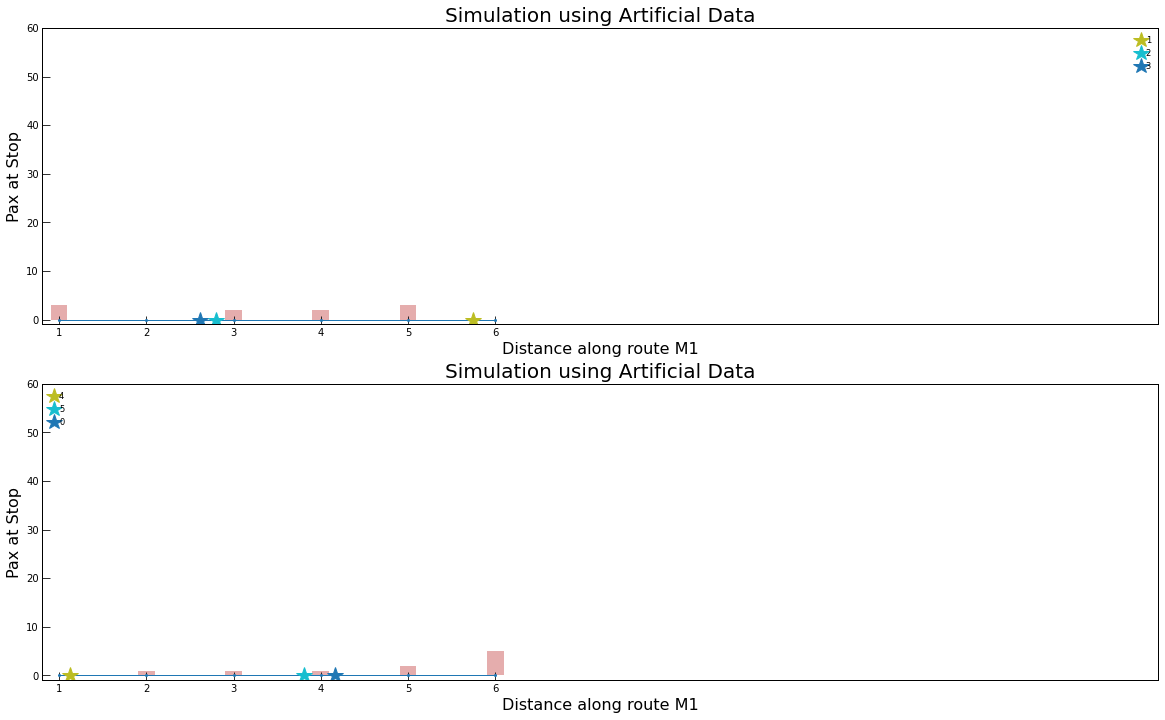

In [3]:
ave_wait_list,std_wait_list,ave_travel_list,std_travel_list,ave_all_list,std_all_list = [],[],[],[],[],[]
for i_ep in range(envConfig.num_episodes):
    env = Env(bus_stop_num=envConfig.Stop_Num,bus_num = envConfig.bus_num_each_dir,
              stop_loc_list=envConfig.Stop_Loc_List,arr_rates = envConfig.Arr_Rates,bus_omega= envConfig.bus_omega,hold_strategy=Hold_Strategy,\
              pax_saturate=envConfig.pax_saturate,ran_travel=envConfig.ran_travel,mu_time = envConfig.mu_time,headway=envConfig.headway,\
              alight_rate=envConfig.alight_rate,board_rate=envConfig.board_rate,warm_up_time = envConfig.warm_up_time)
    step_t = 0
    var = []
    #######Initialize for visualization######
    fig = plt.figure(figsize=(20,12))
    for i in range(envConfig.Dir_Num):
        line[i] = env.lines[i]
        wait_nums = [len(x.pax_list) for x in line[i].stop_list] 
        a,bp,px = gif_init(fig,i,envConfig.Stop_Loc_List[0],line[i].bus_list, wait_nums, envConfig.stop_names[i])
        ax.append(a)
        buses_plot.append(bp)
        pax_bar.append(px)
    while step_t <= envConfig.Sim_Horizon:
        ####update visualization#######
        for i in range(envConfig.Dir_Num):
            wait_nums = [len(x.pax_list) for x in env.lines[i].stop_list]
            if i == 1:
                wait_nums = wait_nums[::-1]
            gif_update(i,fig,ax[i],buses_plot[i],env.lines[i].bus_list,pax_bar[i],wait_nums,step_t)
        clear_output(wait=True)
        display(fig)
        # update environment
        s = env.update(step_t)
        if step_t > envConfig.warm_up_time:
            if Hold_Strategy == 4:
                actions = [-1 for _ in range(envConfig.bus_num)]
                values = np.zeros(envConfig.bus_num,dtype=float)
                local_obs = [[]for _ in range(envConfig.bus_num)]
                exist_ctl = False
                for i in range(envConfig.bus_num):
                    if len(s[i][:])>0:
                        var.append(1/(1.+np.var(np.array(s[i]))))
                        exist_ctl = True
                        local_obs[i].extend([s[i][0],s[i][-1]])
                        current_local_obs = torch.from_numpy(np.array(local_obs[i])).float().to(config.device)
                        current_obs = torch.from_numpy(np.array(s[i])).float().to(config.device)
                        with torch.no_grad():
                            a = model.get_action(current_local_obs)#执行动作
                            v = model.get_value(current_obs)#获得模型
                        actions[i] = a.view(-1).cpu().numpy()
                        values[i] = v.view(-1).cpu().numpy()
                        # print("驻留：",actions[i])
                if exist_ctl == True:
                    # print(s)
                    #把动作，状态，奖励存进memory中
                    model.rollouts.insert(local_obs,s,actions,values,config.w1,config.w2)
                    env.control(actions)
        step_t += 1
    ave_reward = 0
    ave_reward_p1 = 0
    ave_reward_p2 = 0
    length = 0
    # f = plt.figure()
    for i in range(len(model.rollouts.rewards)):
        # print(i,len(model.rollouts.rewards[i]))
        length += len(model.rollouts.rewards[i])
        ave_reward_p1 += sum(model.rollouts.rewards_p1[i])
        ave_reward_p2 += sum(model.rollouts.rewards_p2[i])
        ave_reward += sum(model.rollouts.rewards[i])
        # plt.plot(list(range(len(model.rollouts.actions[i]))),model.rollouts.actions[i])
    
    ave_reward /= length
    ave_reward_p1 /= length
    ave_reward_p2 /= length
    ave_var = sum(var)/len(var)
    print(' num_episodes:%d   r:%g realvar:%g' % (i_ep, ave_reward,ave_var))   
    
    env.save_operate_traj(step_t)
    if i_ep % 100== 0:
        plot_tsd(env.trajectory,envConfig.Sim_Horizon,env.bus_num,envConfig.Stop_Loc_List[0],fig_dir,i_ep)
        
    ave_w,std_w,ave_tr,std_tr,ave_all,std_all = env.cal_ave_time()
    ave_wait_list.append(ave_w)
    std_wait_list.append(std_w)
    ave_travel_list.append(ave_tr)
    std_travel_list.append(std_tr)
    ave_all_list.append(ave_all)
    std_all_list.append(std_all)
    
    #仿真结束，更新网络
    model.rollouts.compute_returns(config.GAMMA)
    model.rollouts.after_epoch()
    value_loss, action_loss= model.update(model.rollouts)
    model.rollouts.after_update()
    v_loss_set.append(value_loss)
    actor_loss_set.append(action_loss)
    model.save_w(model_dir)

In [ ]:
# ave_wait = np.mean(ave_wait_list)
# std_wait = np.mean(std_wait_list)
# ave_travel = np.mean(ave_travel_list)
# std_travel = np.mean(std_travel_list)
# ave_alltime = np.mean(ave_all_list)
# std_alltime = np.mean(std_all_list)
# print("平均等待时间：",ave_wait)
# print("标准差：",std_wait)
# print("平均乘车时间：",ave_travel)
# print("标准差：",std_travel)
# print("average journey time:",ave_alltime)
# print("std:",std_alltime)

if Hold_Strategy == 4:
    #PLOT critic loss
    f = plt.figure()
    ax = plt.subplot(111)
    plt.xlabel('Training episode')
    plt.ylabel('Mean squared error')
    smoothing_window = 10
    v_loss_set_smoothed = pd.Series(v_loss_set).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(v_loss_set, alpha=0.2)
    plt.plot(v_loss_set_smoothed, color='orange')
    plt.grid()
    plt.show()
    f.savefig(os.path.join(fig_dir,"critic.pdf"), bbox_inches='tight')
    #plot actor loss
    f = plt.figure()
    ax = plt.subplot(111)
    plt.xlabel('Training episode')
    plt.ylabel('Actor loss')
    smoothing_window = 10
    a_loss_set_smoothed = pd.Series(actor_loss_set).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(actor_loss_set, alpha=0.2)
    plt.plot(a_loss_set_smoothed, color='orange')
    plt.grid()
    plt.show()
    f.savefig(os.path.join(fig_dir,"actor.pdf"), bbox_inches='tight')
    # plot reward
    f = plt.figure()
    ax = plt.subplot(111)
    ax.tick_params(length=4, width=0.5)
    plt.xlabel('Training episode' )
    plt.ylabel('Cumulative global reward' )
    smoothing_window = 10
    rewards_smoothed = pd.Series(reward_set).rolling(smoothing_window, min_periods=smoothing_window).mean()
    rewards_smoothed1 = pd.Series(reward_p1_set).rolling(smoothing_window, min_periods=smoothing_window).mean()
    rewards_smoothed2 = pd.Series(reward_p2_set).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(reward_set, alpha=0.2)
    plt.plot(rewards_smoothed,color='orange',label='total reward')
    plt.plot(reward_p1_set, alpha=0.2)
    plt.plot(rewards_smoothed1, color='red',label='reward for holding penalty')
    plt.plot(reward_p2_set, alpha=0.2)
    plt.plot(rewards_smoothed2, color='green',label='reward for headway equalization')
    ax.legend(loc='best',  fancybox=True, shadow=False, ncol=1, prop={'size': 12})
    plt.show()
    f.savefig(os.path.join(fig_dir,"reward_train.pdf"), bbox_inches='tight')

org_file = os.path.join(root,"utils/hyperparameters.py")
command = "cp "+org_file+" "+result_path
os.system(command)